In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import math
import matplotlib.pyplot as plt

In [8]:
# create seed
torch.manual_seed(42)
np.random.seed(42)


In [9]:
def load_datasets():
    train_set = pd.read_parquet('loaded_data/a_patient_data_processed_cluster.parquet')
    test_set = pd.read_parquet('loaded_data/c_patient_data_processed_cluster.parquet')
    return train_set, test_set

train_df, test_df = load_datasets()

X_train = torch.tensor(train_df.drop(columns=["ICUType", "In-hospital_death"]).values, dtype=torch.float32)
y_train = torch.tensor(train_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_df.drop(columns=["ICUType", "In-hospital_death"]).values, dtype=torch.float32)
y_test = torch.tensor(test_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)

feature_columns = [col for col in train_df.columns if col not in ["RecordID", "In-hospital_death", "ICUType"]]

grouped = train_df.groupby("RecordID")

def pad_to_fixed_length(tensor, length=49):
    current_length = tensor.size(0)
    if current_length < length:
        padding = torch.zeros((length - current_length, tensor.size(1)))
        return torch.cat([tensor, padding], dim=0)
    else:
        return tensor

def process_dataframe(df):
    list_of_patient_tensors = []
    patient_labels = []
    grouped = df.groupby("RecordID")
    for record_id, group in grouped:
        group_tensor = torch.tensor(group[feature_columns].values, dtype=torch.float32)
        group_tensor_fixed = pad_to_fixed_length(group_tensor, length=49)
        list_of_patient_tensors.append(group_tensor_fixed)
        # For the label, we assume that if any timestep indicates death, the patient is labeled as death (1)
        patient_labels.append(group["In-hospital_death"].max())
    sequences = torch.stack(list_of_patient_tensors, dim=0)  
    labels = torch.tensor(patient_labels, dtype=torch.float32).unsqueeze(1)
    return sequences, labels

# Process training and testing data
padded_sequences_train, labels_tensor_train = process_dataframe(train_df)
padded_sequences_test, labels_tensor_test = process_dataframe(test_df)
print(padded_sequences_train.size(), labels_tensor_train.size())

torch.Size([3997, 49, 41]) torch.Size([3997, 1])


In [10]:
def random_sample(X, y, n_samples):
    indices = np.random.choice(len(X), size=n_samples, replace=False)
    return X[indices], y[indices]

In [31]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=49):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:,:pe[:, 1::2].shape[1]]
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=41, model_dim=64, num_heads=4, num_layers=2, num_classes=1, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(d_model=model_dim, max_len=49)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(model_dim, num_classes)
    
    def forward(self, x):
        x = self.input_linear(x)          
        x = self.positional_encoding(x)  
        x = x.transpose(0, 1)             
        x = self.transformer_encoder(x)   
        x = x.mean(dim=0)          
        logits = self.classifier(x) 
        return logits




In [32]:
def train_model(model, train_loader, criterion, optimizer, device):
    num_epochs = 30
    epoch_losses = [] 

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        num_batches = len(train_loader)
        
        for batch_data, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()           # Zero the gradients
            logits = model(batch_data)        # Forward pass
            loss = criterion(logits, batch_labels)  # Compute loss
            loss.backward()                   # Backpropagation
            optimizer.step()                  # Update weights
            
            running_loss += loss.item()       # Accumulate batch loss
        
        avg_loss = running_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

    # Plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    return model


In [33]:

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            logits = model(batch_data)
            loss = criterion(logits, batch_labels)
            
            batch_size = batch_data.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Convert logits to probabilities and then binary predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(batch_labels.cpu())
    
    # Compute average loss over all samples
    avg_loss = total_loss / total_samples
    
    # Concatenate all predictions, probabilities, and labels
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Overall accuracy
    overall_accuracy = (all_preds.eq(all_labels)).float().mean().item()
    
    # Accuracy for predicting 1 (sensitivity): among all true positives, how many were predicted as 1
    pos_idx = (all_labels == 1).squeeze()
    if pos_idx.sum() > 0:
        accuracy_pos = (all_preds[pos_idx].eq(all_labels[pos_idx])).float().mean().item()
    else:
        accuracy_pos = float('nan')
    
    # Accuracy for predicting 0 (specificity): among all true negatives, how many were predicted as 0
    neg_idx = (all_labels == 0).squeeze()
    if neg_idx.sum() > 0:
        accuracy_neg = (all_preds[neg_idx].eq(all_labels[neg_idx])).float().mean().item()
    else:
        accuracy_neg = float('nan')
    
    # Compute AUROC using probabilities (make sure to flatten the arrays)
    # Compute AUPRC
    try:
        auroc = roc_auc_score(all_labels.numpy(), all_probs.numpy())
        auprc = average_precision_score(all_labels.numpy(), all_probs.numpy())
    except Exception as e:
        auroc = None
        print("Error computing AUROC:", e)
    
    return avg_loss, overall_accuracy, accuracy_pos, accuracy_neg, auroc, auprc


In [34]:
# Create TensorDatasets and DataLoaders
batch_size = 32



test_dataset = TensorDataset(padded_sequences_test, labels_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/30] - Average Loss: 1.2938


Epoch [2/30] - Average Loss: 1.1570


Epoch [3/30] - Average Loss: 1.4619


Epoch [4/30] - Average Loss: 1.2527


Epoch [5/30] - Average Loss: 1.1552


Epoch [6/30] - Average Loss: 1.5371


Epoch [7/30] - Average Loss: 0.9539


Epoch [8/30] - Average Loss: 0.9748


Epoch [9/30] - Average Loss: 0.9179


Epoch [10/30] - Average Loss: 1.1643


Epoch [11/30] - Average Loss: 0.8635


Epoch [12/30] - Average Loss: 0.7950


Epoch [13/30] - Average Loss: 1.7069


Epoch [14/30] - Average Loss: 0.8784


Epoch [15/30] - Average Loss: 1.0509


Epoch [16/30] - Average Loss: 0.9680


Epoch [17/30] - Average Loss: 0.7142


Epoch [18/30] - Average Loss: 0.7279


Epoch [19/30] - Average Loss: 0.6039


Epoch [20/30] - Average Loss: 0.5430


Epoch [21/30] - Average Loss: 0.4966


Epoch [22/30] - Average Loss: 0.9579


Epoch [23/30] - Average Loss: 1.0873


Epoch [24/30] - Average Loss: 0.5723


Epoch [25/30] - Average Loss: 1.2700


Epoch [26/30] - Average Loss: 0.7460


Epoch [27/30] - Average Loss: 0.5199


Epoch [28/30] - Average Loss: 0.6172


Epoch [29/30] - Average Loss: 0.5312


Epoch [30/30] - Average Loss: 0.4726


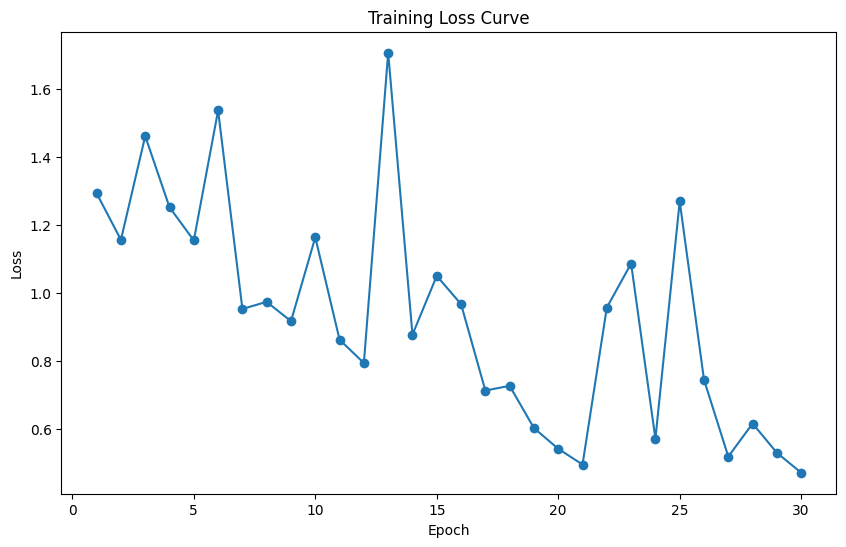

Test Loss: 2.7357
Overall Accuracy: 83.17%
Accuracy for predicting 1 (Sensitivity): 12.82%
Accuracy for predicting 0 (Specificity): 95.22%
AUROC: 0.5244
AUPRC: 0.1832


In [35]:
num_samples = 100


X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([9.0]))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/30] - Average Loss: 1.3502


Epoch [2/30] - Average Loss: 1.2807


Epoch [3/30] - Average Loss: 1.0921


Epoch [4/30] - Average Loss: 0.9922


Epoch [5/30] - Average Loss: 0.9521


Epoch [6/30] - Average Loss: 0.9600


Epoch [7/30] - Average Loss: 0.9676


Epoch [8/30] - Average Loss: 0.9285


Epoch [9/30] - Average Loss: 0.8378


Epoch [10/30] - Average Loss: 0.8010


Epoch [11/30] - Average Loss: 0.8132


Epoch [12/30] - Average Loss: 0.7895


Epoch [13/30] - Average Loss: 0.7401


Epoch [14/30] - Average Loss: 0.7200


Epoch [15/30] - Average Loss: 0.6229


Epoch [16/30] - Average Loss: 0.5504


Epoch [17/30] - Average Loss: 0.5189


Epoch [18/30] - Average Loss: 0.4732


Epoch [19/30] - Average Loss: 0.4456


Epoch [20/30] - Average Loss: 0.3823


Epoch [21/30] - Average Loss: 0.3870


Epoch [22/30] - Average Loss: 0.3563


Epoch [23/30] - Average Loss: 0.3281


Epoch [24/30] - Average Loss: 0.2252


Epoch [25/30] - Average Loss: 0.2612


Epoch [26/30] - Average Loss: 0.3102


Epoch [27/30] - Average Loss: 0.2675


Epoch [28/30] - Average Loss: 0.2186


Epoch [29/30] - Average Loss: 0.1940


Epoch [30/30] - Average Loss: 0.1652


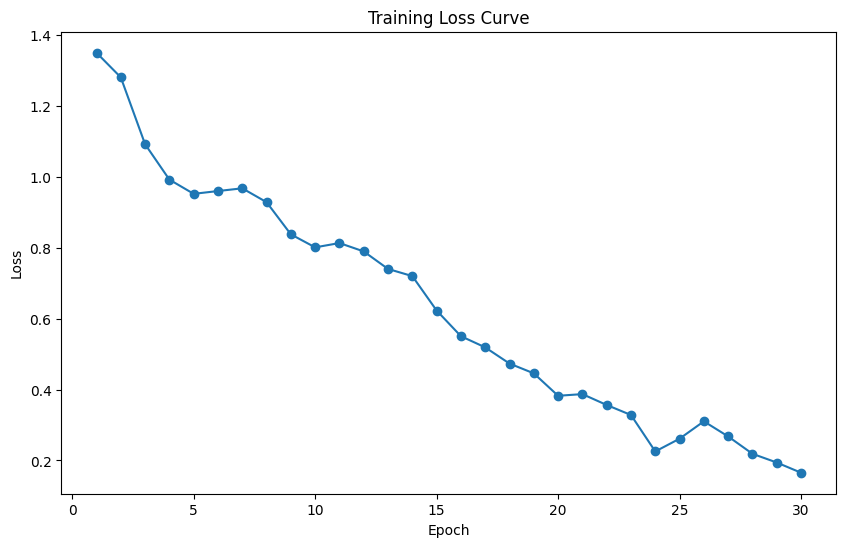

Test Loss: 3.8109
Overall Accuracy: 80.94%
Accuracy for predicting 1 (Sensitivity): 30.94%
Accuracy for predicting 0 (Specificity): 89.51%
AUROC: 0.7328
AUPRC: 0.3178


In [36]:
num_samples = 500


X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([9.0]))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/30] - Average Loss: 1.4527


Epoch [2/30] - Average Loss: 1.3340


Epoch [3/30] - Average Loss: 1.2098


Epoch [4/30] - Average Loss: 1.1340


Epoch [5/30] - Average Loss: 1.1264


Epoch [6/30] - Average Loss: 1.0616


Epoch [7/30] - Average Loss: 1.0112


Epoch [8/30] - Average Loss: 0.9731


Epoch [9/30] - Average Loss: 0.9488


Epoch [10/30] - Average Loss: 0.8962


Epoch [11/30] - Average Loss: 0.8613


Epoch [12/30] - Average Loss: 0.7916


Epoch [13/30] - Average Loss: 0.7656


Epoch [14/30] - Average Loss: 0.7335


Epoch [15/30] - Average Loss: 0.7393


Epoch [16/30] - Average Loss: 0.7161


Epoch [17/30] - Average Loss: 0.6329


Epoch [18/30] - Average Loss: 0.6313


Epoch [19/30] - Average Loss: 0.5416


Epoch [20/30] - Average Loss: 0.5190


Epoch [21/30] - Average Loss: 0.5809


Epoch [22/30] - Average Loss: 0.5002


Epoch [23/30] - Average Loss: 0.4147


Epoch [24/30] - Average Loss: 0.3898


Epoch [25/30] - Average Loss: 0.3705


Epoch [26/30] - Average Loss: 0.3594


Epoch [27/30] - Average Loss: 0.3052


Epoch [28/30] - Average Loss: 0.3026


Epoch [29/30] - Average Loss: 0.2993


Epoch [30/30] - Average Loss: 0.2860


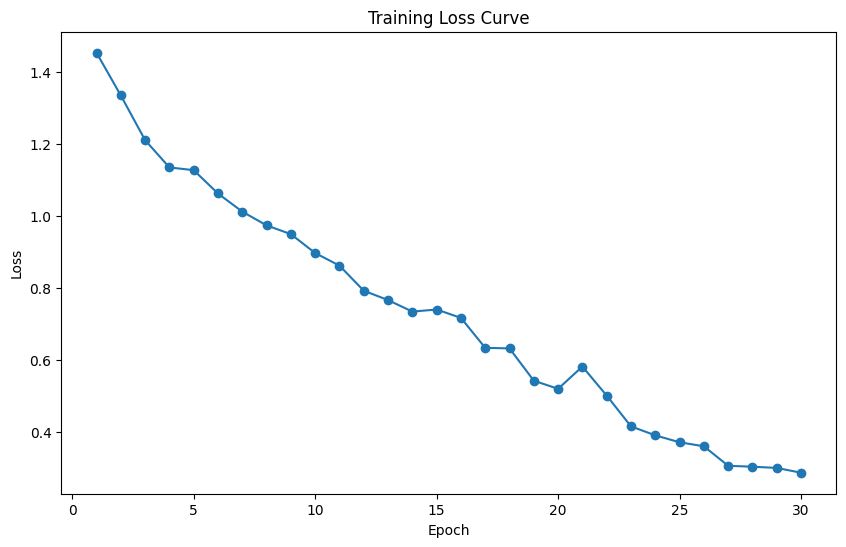

Test Loss: 2.8434
Overall Accuracy: 78.96%
Accuracy for predicting 1 (Sensitivity): 52.14%
Accuracy for predicting 0 (Specificity): 83.56%
AUROC: 0.7658
AUPRC: 0.3491


In [37]:
num_samples = 1000

X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([9.0]))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/30] - Average Loss: 1.2942


Epoch [2/30] - Average Loss: 1.1451


Epoch [3/30] - Average Loss: 1.0674


Epoch [4/30] - Average Loss: 1.0727


Epoch [5/30] - Average Loss: 1.0333


Epoch [6/30] - Average Loss: 1.0044


Epoch [7/30] - Average Loss: 0.9645


Epoch [8/30] - Average Loss: 0.9604


Epoch [9/30] - Average Loss: 0.9215


Epoch [10/30] - Average Loss: 0.8773


Epoch [11/30] - Average Loss: 0.8734


Epoch [12/30] - Average Loss: 0.8489


Epoch [13/30] - Average Loss: 0.8467


Epoch [14/30] - Average Loss: 0.8104


Epoch [15/30] - Average Loss: 0.7549


Epoch [16/30] - Average Loss: 0.7380


Epoch [17/30] - Average Loss: 0.7450


Epoch [18/30] - Average Loss: 0.7250


Epoch [19/30] - Average Loss: 0.6740


Epoch [20/30] - Average Loss: 0.6360


Epoch [21/30] - Average Loss: 0.6419


Epoch [22/30] - Average Loss: 0.5952


Epoch [23/30] - Average Loss: 0.5874


Epoch [24/30] - Average Loss: 0.5400


Epoch [25/30] - Average Loss: 0.5168


Epoch [26/30] - Average Loss: 0.4820


Epoch [27/30] - Average Loss: 0.4454


Epoch [28/30] - Average Loss: 0.4304


Epoch [29/30] - Average Loss: 0.4228


Epoch [30/30] - Average Loss: 0.3731


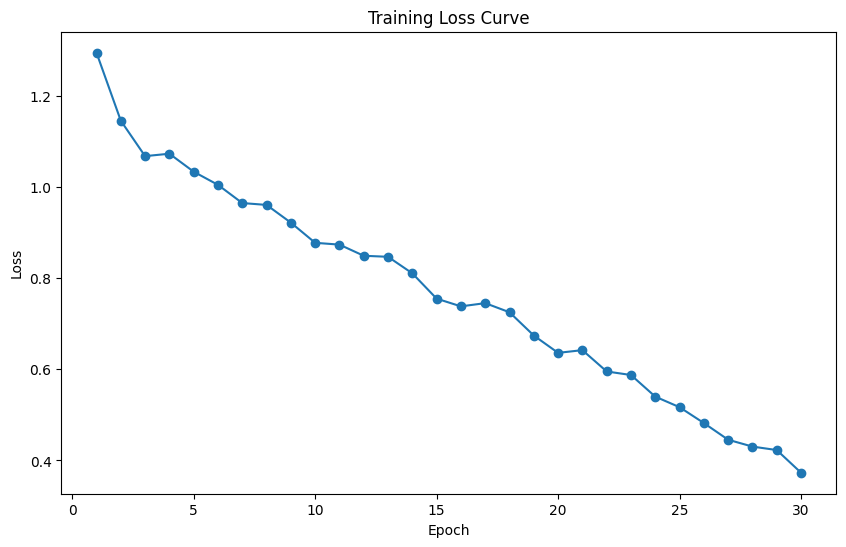

Test Loss: 2.3685
Overall Accuracy: 78.04%
Accuracy for predicting 1 (Sensitivity): 58.63%
Accuracy for predicting 0 (Specificity): 81.37%
AUROC: 0.7859
AUPRC: 0.4038


In [38]:
# All of the data

train_dataset = TensorDataset(padded_sequences_train, labels_tensor_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([9.0]))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")